# Risk forecasting DNN model

### Hyperparameters

In [1]:
# options
ACTIVE_LEARNING = True
PROGRESSIVE_TRAINING = True
BASELINE = True
LOW_BIT_TRAINING = False

# data params
SERIES_INTERVAL = '1d'
LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.9

# general model params 
EPOCHS = 70
BATCH_SIZE = 32
NODES_PER_LAYER = 128

# active learning params
AL_ITERATIONS = 70
AL_SAMPLE = 100
AL_EPOCHS = 2

# progressive training params
PRETRAINING_EPOCHS = 20
TUNING_EPOCHS = 30

# low-bit training
MIXED_PRECISION = 'mixed_float16'
HIGH_PRECISION = 'float32'

### Imports

In [2]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from time import time
import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.stats import norm

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-299eea69-e587-70b9-1843-89aabab388fd)


### Mixed Precision Training

In [5]:
# create dtype policy, specifying dtype layers run in
if LOW_BIT_TRAINING:
    policy = mixed_precision.Policy(MIXED_PRECISION)
else:
    policy = mixed_precision.Policy(HIGH_PRECISION)

mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


### Data curation and manipulation

In [6]:
# formula for historical volatility
def compute_volatility(window):
    _v = window - np.mean(window)
    _v = np.square(_v)
    _v = np.sum(_v)
    _v = _v / LOOKBACK_WINDOW
    _v = np.sqrt(_v)

    return _v

In [7]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(start='1950-01-04', end='2022-08-02', interval=SERIES_INTERVAL)

close = sp500_history.Close.loc[sp500_history.Close != 0]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = [compute_volatility(log_returns[i: i + LOOKBACK_WINDOW]) for i in range(log_returns.shape[0] - LOOKBACK_WINDOW)]

# gather other variables
_open = sp500_history.Open[1:]
_high = sp500_history.High[1:]
_low = sp500_history.Low[1:]
_volume = sp500_history.Volume[1:]

close = close[1:]
volatility = pd.Series(volatility, index=log_returns[LOOKBACK_WINDOW:].keys())

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'close': (close - close.min()) / close.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'returns': log_returns / np.abs(log_returns).max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# fill nan values in volatility column (these won't be used)
X.volatility = X.volatility.fillna(0)

X

,open,close,high,low,volume,returns,volatility
Date,,,,,,,
1950-01-05,0.003524,0.000054,0.000054,0.000054,0.000163,0.020684,0.000000
1950-01-06,0.003534,0.000065,0.000064,0.000065,0.000116,0.012878,0.000000
1950-01-09,0.003555,0.000085,0.000085,0.000086,0.000161,0.025642,0.000000
1950-01-10,0.003545,0.000075,0.000075,0.000075,0.000129,-0.012802,0.000000
1950-01-11,0.003557,0.000088,0.000087,0.000088,0.000170,0.015358,0.000000
...,...,...,...,...,...,...,...
2022-07-26,0.822814,0.813996,0.816945,0.814652,0.269089,-0.050701,0.126826
2022-07-27,0.822442,0.835378,0.834864,0.823165,0.312798,0.112753,0.129777
2022-07-28,0.837990,0.845556,0.843038,0.831855,0.338870,0.052666,0.147466


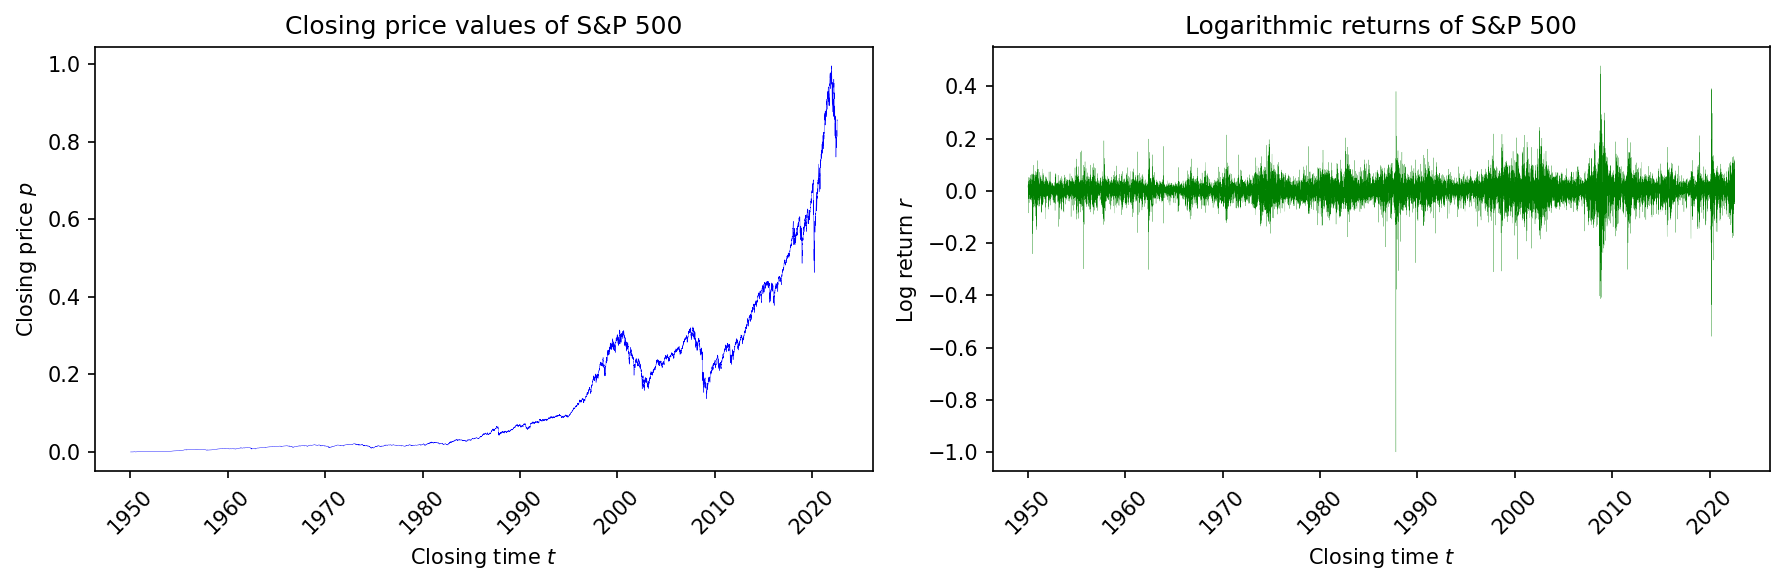

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

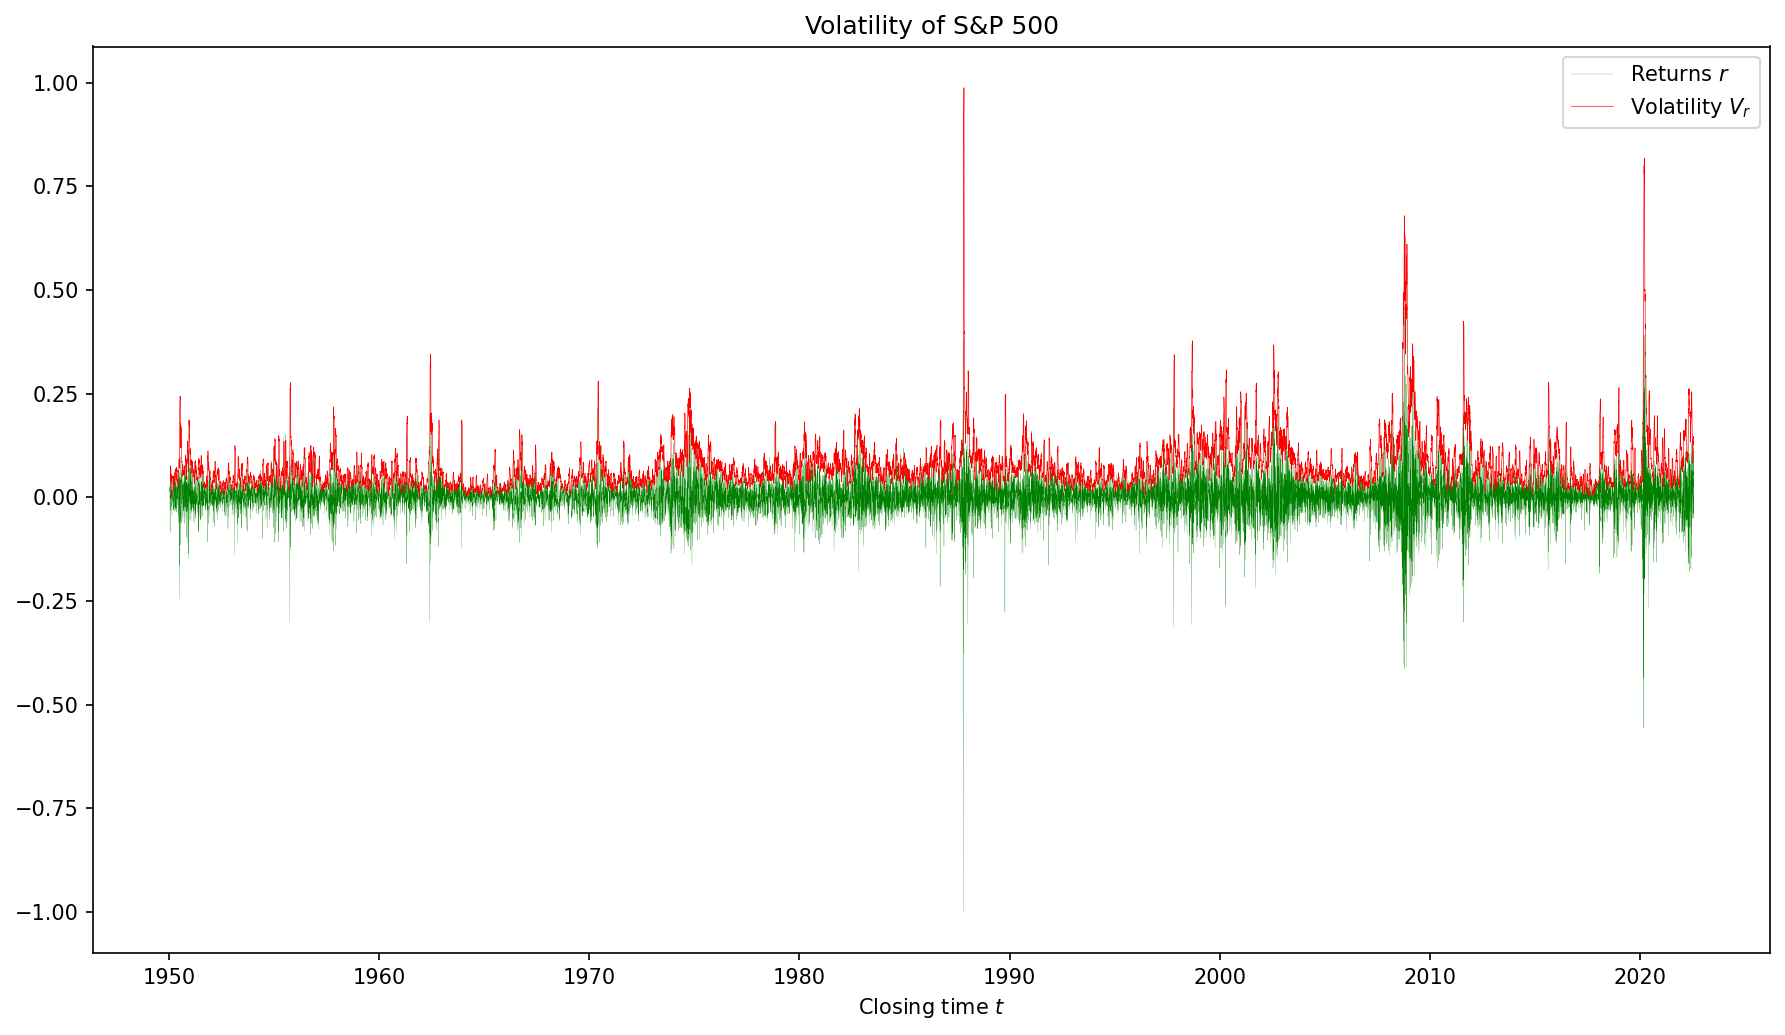

In [9]:
# plot computed volatility
fig, ax = plt.subplots(figsize=(12, 7), dpi=150)

ax.plot(X.returns, linewidth=0.1, color='g', label='Returns $r$')
ax.plot(X.volatility, linewidth=0.3, color='r', label='Volatility $V_r$')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$')
ax.legend()

plt.tight_layout()
plt.show()

In [10]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW):
    # compute volatility 
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + 1])

# convert X, y to numpy arrays (and scale volatility)
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:split]
y_train = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]

X_train, y_train = shuffle(X_train, y_train)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print("Train:", X_train.shape, y_train.shape, '\nTest: ', X_test.shape, y_test.shape)

90% training data, 10% testing data
Train: (16425, 10, 7) (16425, 1) 
Test:  (1826, 10, 7) (1826, 1)


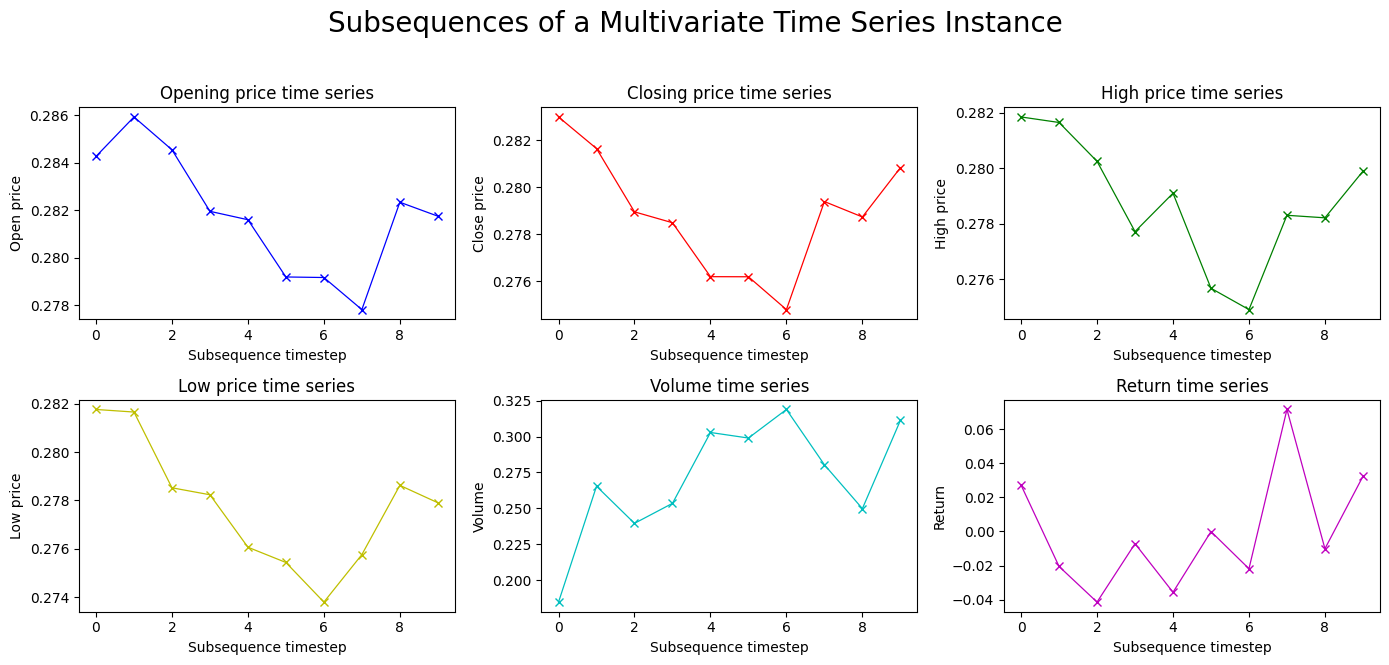

In [11]:
# examples of individual variable time series instance
fig, ax = plt.subplots(2, 3, figsize=(14, 6), dpi=100)
fig.suptitle("Subsequences of a Multivariate Time Series Instance", fontsize=20, y=1.1)

np.random.seed(123)
random_index = np.random.randint(0, y_data.shape[0])
time_series = X_data[random_index]
label = y_data[random_index][0]

ax[0, 0].plot(time_series[:, 0], color='b', marker='x', linewidth=0.9)
ax[0, 0].set(title=f'Opening price time series', xlabel=r'Subsequence timestep', ylabel=r'Open price')

ax[0, 1].plot(time_series[:, 1], color='r', marker='x', linewidth=0.9)
ax[0, 1].set(title=f'Closing price time series', xlabel=r'Subsequence timestep', ylabel=r'Close price')

ax[0, 2].plot(time_series[:, 2], color='g', marker='x', linewidth=0.9)
ax[0, 2].set(title=f'High price time series', xlabel=r'Subsequence timestep', ylabel=r'High price')

ax[1, 0].plot(time_series[:, 3], color='y', marker='x', linewidth=0.9)
ax[1, 0].set(title=f'Low price time series', xlabel=r'Subsequence timestep', ylabel=r'Low price')

ax[1, 1].plot(time_series[:, 4], color='c', marker='x', linewidth=0.9)
ax[1, 1].set(title=f'Volume time series', xlabel=r'Subsequence timestep', ylabel=r'Volume')

ax[1, 2].plot(time_series[:, 5], color='m', marker='x', linewidth=0.9)
ax[1, 2].set(title=f'Return time series', xlabel=r'Subsequence timestep', ylabel=r'Return')

plt.tight_layout()
plt.show()

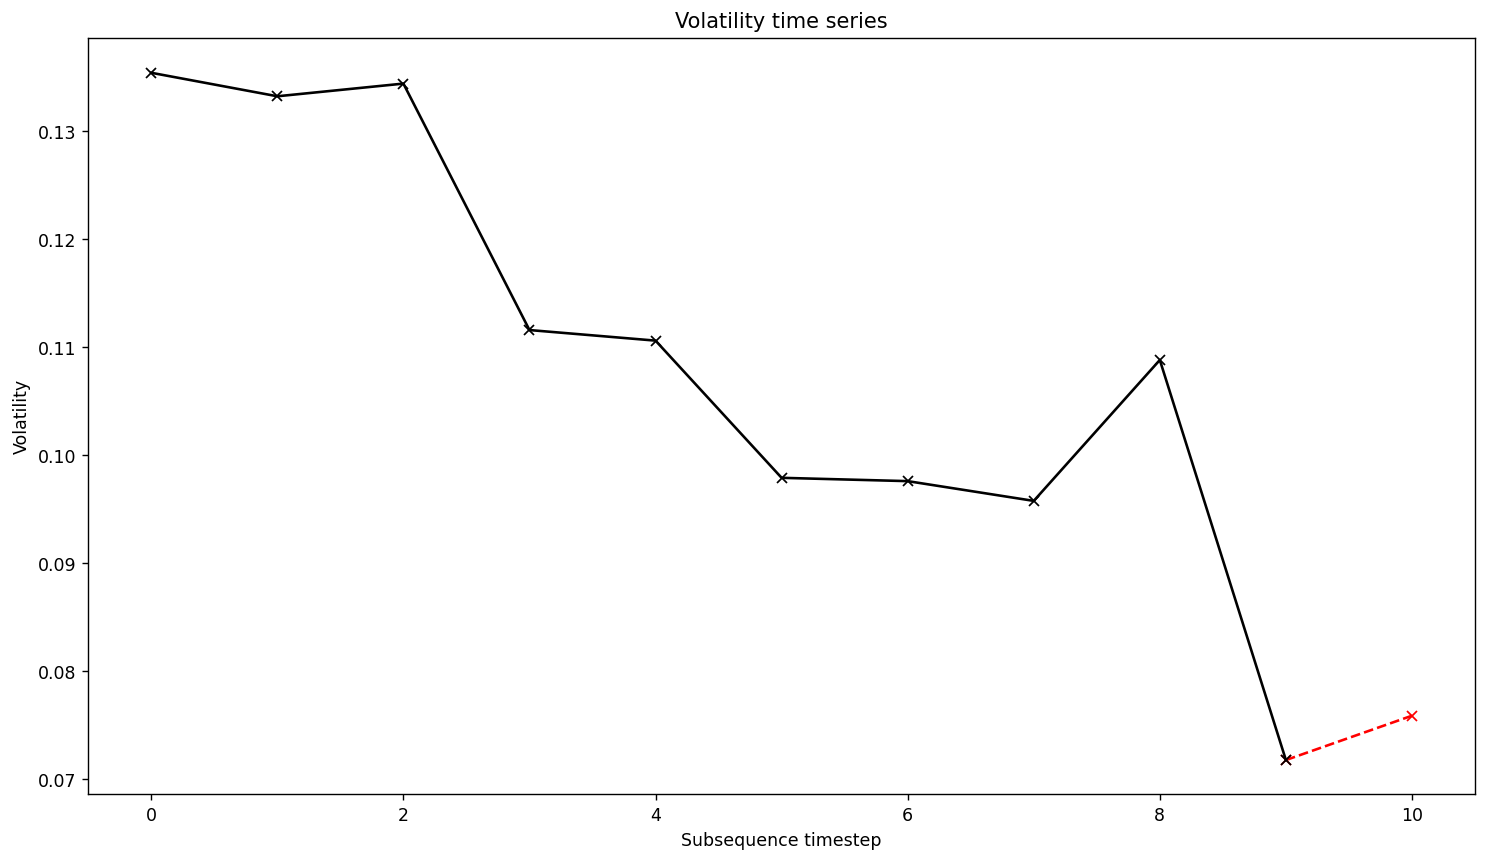

In [12]:
# example of volatility time series instance
fig, ax = plt.subplots(figsize=(12, 7), dpi=125)

ax.plot([9, 10], [time_series[:, 6][-1], label], color='r', marker='x', linestyle='dashed')
ax.plot(time_series[:, 6], color='k', marker='x')
ax.set(title=f'Volatility time series', xlabel=r'Subsequence timestep', ylabel=r'Volatility')

plt.tight_layout()
plt.show()

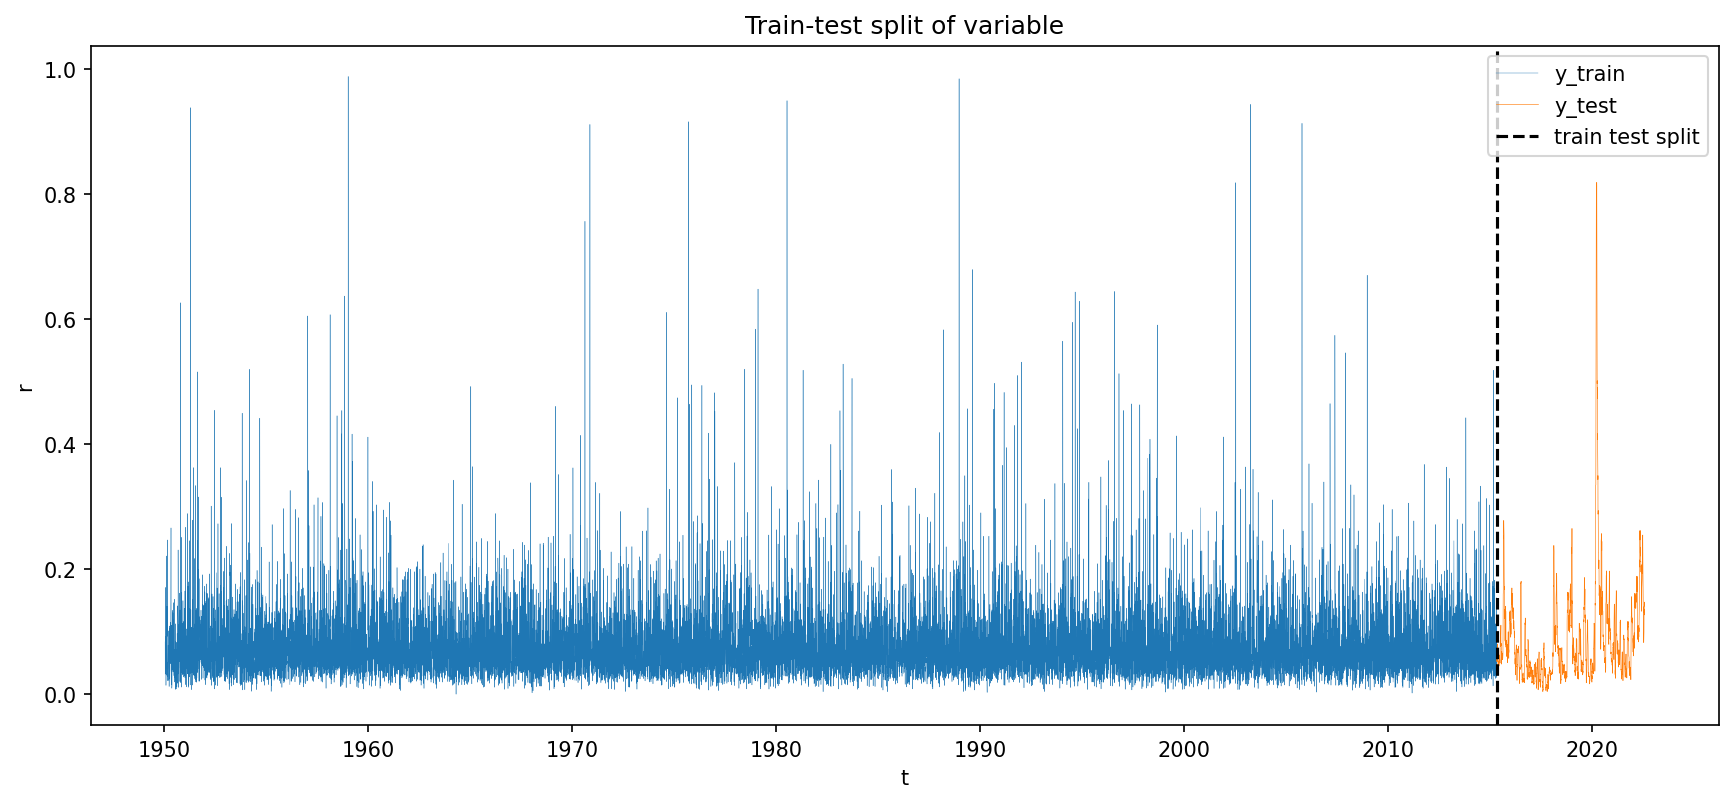

In [13]:
# plot the train-test split data
fig, ax = plt.subplots(figsize=(14, 6), dpi=150)

y_train_plot = y_train.flatten()
y_train_plot = pd.Series(y_train_plot, index=X.volatility[LOOKBACK_WINDOW: LOOKBACK_WINDOW + split].keys())

y_test_plot = y_test.flatten()
y_test_plot = pd.Series(y_test_plot, index=X.volatility[LOOKBACK_WINDOW + split:].keys())

ax.plot(y_train_plot, label='y_train', linewidth=0.2)
ax.plot(y_test_plot, label='y_test', linewidth=0.3)
ax.axvline(y_test_plot.keys()[0], color='k', linestyle='--', label='train test split')

ax.set(title='Train-test split of variable', xlabel='t', ylabel='r')
ax.legend()

plt.show()

### Baseline comparison model (basic non-active, non-layer-wise training)

In [14]:
if BASELINE:
    # comparative model to progressively trained model
    comp_model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, input_shape=(X_train.shape[1:]), activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
        Dense(1, activation='linear')
    ])

    # compile and train comparison model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    comp_model.compile(loss='mae', optimizer=optim, metrics=['mse'])
    
    # train and evaluate 
    start_comp = time()
    hist = comp_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    total_time_comp = time() - start_comp
    history_comp = hist.history

    test_loss, test_acc = comp_model.evaluate(X_test, y_test)

Epoch 1/70
52/52 [==============================] - 8s 55ms/step - loss: 0.0275 - mse: 0.0019 - val_loss: 0.0205 - val_mse: 0.0011
Epoch 2/70
52/52 [==============================] - 2s 35ms/step - loss: 0.0191 - mse: 8.8259e-04 - val_loss: 0.0196 - val_mse: 9.1008e-04
Epoch 3/70
52/52 [==============================] - 2s 36ms/step - loss: 0.0160 - mse: 6.2483e-04 - val_loss: 0.0172 - val_mse: 6.8901e-04
Epoch 4/70
52/52 [==============================] - 2s 36ms/step - loss: 0.0156 - mse: 5.8838e-04 - val_loss: 0.0138 - val_mse: 4.5553e-04
Epoch 5/70
52/52 [==============================] - 2s 36ms/step - loss: 0.0126 - mse: 3.6794e-04 - val_loss: 0.0118 - val_mse: 3.8324e-04
Epoch 6/70
52/52 [==============================] - 2s 36ms/step - loss: 0.0119 - mse: 3.6856e-04 - val_loss: 0.0131 - val_mse: 3.8140e-04
Epoch 7/70
52/52 [==============================] - 2s 36ms/step - loss: 0.0115 - mse: 3.5266e-04 - val_loss: 0.0098 - val_mse: 2.7393e-04
Epoch 8/70
52/52 [=================

In [15]:
if BASELINE:
    # Comparison model architecture
    comp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           69632     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
_________________________________________________________________


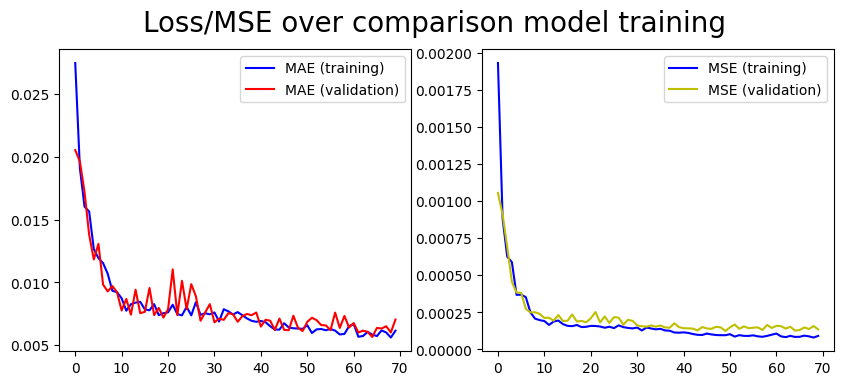

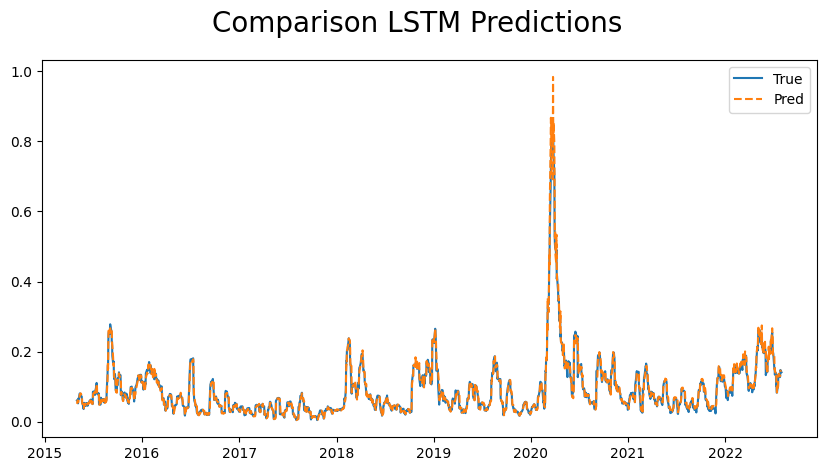

In [16]:
if BASELINE:
    # training loss plots
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
    fig.suptitle("Loss/MSE over comparison model training", fontsize=20)

    ax[0].plot(history_comp['loss'], color='b', label="MAE (training)")
    ax[0].plot(history_comp['val_loss'], color='r', label="MAE (validation)")
    ax[0].legend(loc=0)

    ax[1].plot(history_comp['mse'], color='b', label="MSE (training)")
    ax[1].plot(history_comp['val_mse'], color='y', label="MSE (validation)")
    ax[1].legend(loc=0)


    # prediction plot
    y_pred_comp = comp_model.predict(X_test)
    y_pred_comp = y_pred_comp.flatten()
    y_pred_plot = pd.Series(y_pred_comp, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    y_test_plot = pd.Series(y_test.flatten(), index=X.returns[split + LOOKBACK_WINDOW:].keys())

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
    fig.suptitle("Comparison LSTM Predictions", fontsize=20)

    ax.plot(y_test_plot, label='True')
    ax.plot(y_pred_plot, linestyle='--', label='Pred')
    ax.legend(loc=0)

    plt.show()

In [17]:
if BASELINE:
    # metrics
    mae = np.abs(np.subtract(y_test.flatten(), y_pred_comp)).mean()
    mse = np.square(np.subtract(y_test.flatten(), y_pred_comp)).mean()
    mape = np.abs((y_test.flatten() - y_pred_comp) / y_test.flatten()).mean() * 100
    
    _msle = pd.DataFrame(np.subtract(np.log(y_test.flatten() + 1), np.log(y_pred_comp + 1)))
    _msle.dropna(inplace=True)
    msle = float(np.square(_msle).mean())

    print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")
    print(f"training time = {total_time_comp:.2f}s")

mae = 0.00696; mse = 0.00018; msle = 0.00011; mape = 10.08702%
training time = 140.07s


### Supervised layer-wise training

In [18]:
# supervised progressive training
def base_model(X, y):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
        Dense(1, activation='linear')
    ])
    
    # compile and train base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])
    
    _start = time()
    hist = model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


def progress_layers(model, X, y, history, ret_seq=False):
    # save then remove output layer
    output = model.layers[-1]
    model.pop()

    # halt training on existing layers
    for l in model.layers: l.trainable = False

    # add new layer and restore output layer
    model.add(
        LSTM(NODES_PER_LAYER, return_sequences=ret_seq, activation='tanh')
    )
    model.add(output)

    # retrain newest layer (+ output layer)
    _start = time()
    hist = model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])
    history['mse'].extend(hist.history['mse'])
    history['val_mse'].extend(hist.history['val_mse'])

    return model, history, _timer


def final_training(model, X, y):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='linear'))

    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train regressor
    _start = time()
    history = model.fit(X, y, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start
    
    return model, history.history, _timer

In [19]:
if PROGRESSIVE_TRAINING:
    sup_model, history_sup_pretraining, pretrain_time_sup = base_model(X_train, y_train)
    test_loss_1, test_acc_1 = sup_model.evaluate(X_test, y_test)

    sup_model, history_sup_pretraining, timer = progress_layers(sup_model, X_train, y_train, history_sup_pretraining, ret_seq=True)
    pretrain_time_sup += timer
    test_loss_2, test_acc_2 = sup_model.evaluate(X_test, y_test)

    sup_model, history_sup_tuning, tuning_time_sup = final_training(sup_model, X_train, y_train)

Epoch 1/20
52/52 [==============================] - 3s 33ms/step - loss: 0.0297 - mse: 0.0024 - val_loss: 0.0232 - val_mse: 0.0015
Epoch 2/20
52/52 [==============================] - 1s 29ms/step - loss: 0.0223 - mse: 0.0014 - val_loss: 0.0226 - val_mse: 0.0014
Epoch 3/20
52/52 [==============================] - 1s 29ms/step - loss: 0.0212 - mse: 0.0012 - val_loss: 0.0215 - val_mse: 0.0013
Epoch 4/20
52/52 [==============================] - 1s 26ms/step - loss: 0.0206 - mse: 0.0012 - val_loss: 0.0207 - val_mse: 0.0012
Epoch 5/20
52/52 [==============================] - 1s 26ms/step - loss: 0.0205 - mse: 0.0012 - val_loss: 0.0201 - val_mse: 0.0012
Epoch 6/20
52/52 [==============================] - 1s 29ms/step - loss: 0.0198 - mse: 0.0011 - val_loss: 0.0199 - val_mse: 0.0012
Epoch 7/20
52/52 [==============================] - 2s 29ms/step - loss: 0.0197 - mse: 0.0011 - val_loss: 0.0195 - val_mse: 0.0011
Epoch 8/20
52/52 [==============================] - 1s 29ms/step - loss: 0.0193 - m

In [20]:
if PROGRESSIVE_TRAINING:
    # Supervised model architecture
    sup_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 128)           69632     
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
_________________________________________________________________


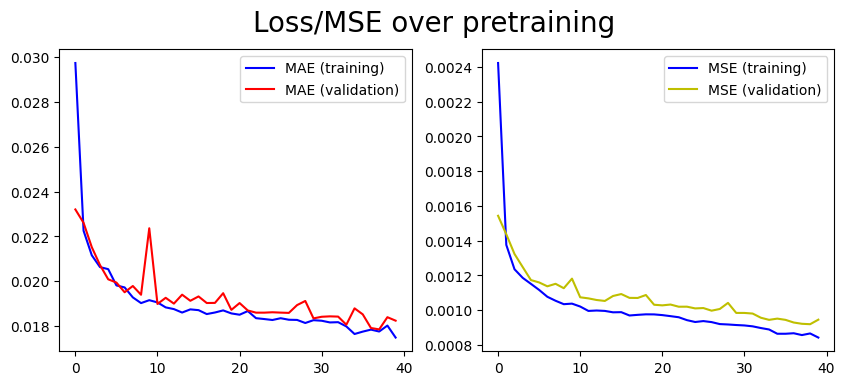

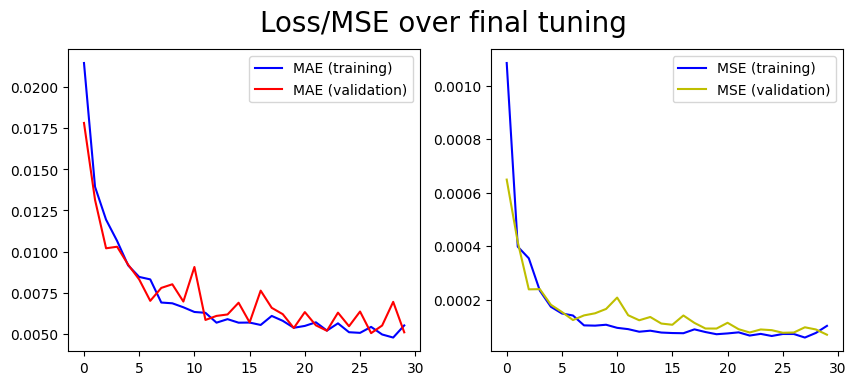

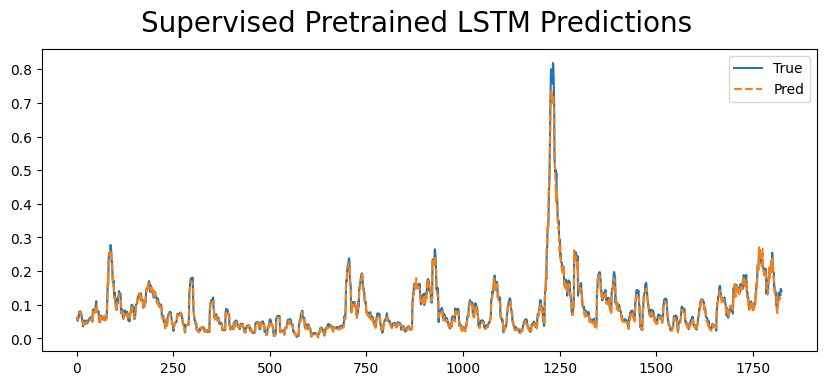

In [21]:
if PROGRESSIVE_TRAINING:
    # pretraining loss plots
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
    fig.suptitle("Loss/MSE over pretraining", fontsize=20)

    ax[0].plot(history_sup_pretraining['loss'], color='b', label="MAE (training)")
    ax[0].plot(history_sup_pretraining['val_loss'], color='r', label="MAE (validation)")
    ax[0].legend(loc=0)

    ax[1].plot(history_sup_pretraining['mse'], color='b', label="MSE (training)")
    ax[1].plot(history_sup_pretraining['val_mse'], color='y', label="MSE (validation)")
    ax[1].legend(loc=0)


    # tuning loss plots
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
    fig.suptitle("Loss/MSE over final tuning", fontsize=20)

    ax[0].plot(history_sup_tuning['loss'], color='b', label="MAE (training)")
    ax[0].plot(history_sup_tuning['val_loss'], color='r', label="MAE (validation)")
    ax[0].legend(loc=0)

    ax[1].plot(history_sup_tuning['mse'], color='b', label="MSE (training)")
    ax[1].plot(history_sup_tuning['val_mse'], color='y', label="MSE (validation)")
    ax[1].legend(loc=0)


    # prediction plot
    y_pred_sup = sup_model.predict(X_test)
    y_pred_sup = y_pred_sup.flatten()

    fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=100)
    fig.suptitle("Supervised Pretrained LSTM Predictions", fontsize=20)

    ax.plot(y_test.flatten(), label='True')
    ax.plot(y_pred_sup, linestyle='--', label='Pred')
    ax.legend(loc=0)

    plt.show()

In [22]:
if PROGRESSIVE_TRAINING:
    # metrics
    mae = np.abs(np.subtract(y_test.flatten(), y_pred_sup)).mean()
    mse = np.square(np.subtract(y_test.flatten(), y_pred_sup)).mean()
    mape = np.abs((y_test.flatten() - y_pred_sup) / y_test.flatten()).mean() * 100

    _msle = pd.DataFrame(np.subtract(np.log(y_test.flatten() + 1), np.log(y_pred_sup + 1)))
    _msle.dropna(inplace=True)
    msle = float(np.square(_msle).mean())

    print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")
    print(f"pretraining time = {pretrain_time_sup:.2f}s; final tuning time = {tuning_time_sup:.2f}s; total time = {pretrain_time_sup + tuning_time_sup:.2f}s")

mae = 0.00727; mse = 0.00011; msle = 0.00008; mape = 10.55423%
pretraining time = 59.68s; final tuning time = 62.39s; total time = 122.07s


### Unsupervised layer-wise training

In [23]:
# unsupervised layer-wise training
def base_autoencoder(X):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, activation='tanh', return_sequences=True, input_shape=(X.shape[1:])),
        TimeDistributed(Dense(X.shape[2]))
    ])

    # compile base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mse', optimizer=optim)

    # train model as an autoencoder that recreates its inputs (minimising mse between input and ouput)
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


def add_autoencoder(model, X, history):
    # stash output layer
    output = model.layers[-1]
    model.pop()

    # fix weights of autoencoder layers (note, this is redundant if `evaluate_regression` called beforehand)
    for l in model.layers: l.trainable = False

    # add new autoencoder layer and read output layer
    model.add(LSTM(NODES_PER_LAYER, activation='tanh', return_sequences=True))
    model.add(output)

    # train new autoencoder layer
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    # collect metrics
    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])

    return model, history, _timer


def build_final_model(model, X, y):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    
    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train regressor
    _start = time()
    history = model.fit(X, y, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, history.history, _timer

In [24]:
if PROGRESSIVE_TRAINING:
    encoder, enc_history, total_enc_time = base_autoencoder(X_train)
    encoder, enc_history, timer = add_autoencoder(encoder, X_train, enc_history)
    total_enc_time += timer
    
    regressor, reg_history, total_reg_time = build_final_model(encoder, X_train, y_train)

Epoch 1/20
52/52 [==============================] - 3s 36ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 2/20
52/52 [==============================] - 1s 29ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/20
52/52 [==============================] - 1s 29ms/step - loss: 8.1999e-04 - val_loss: 6.3849e-04
Epoch 4/20
52/52 [==============================] - 1s 21ms/step - loss: 5.4564e-04 - val_loss: 4.3650e-04
Epoch 5/20
52/52 [==============================] - 1s 29ms/step - loss: 3.7275e-04 - val_loss: 2.9665e-04
Epoch 6/20
52/52 [==============================] - 1s 29ms/step - loss: 2.5615e-04 - val_loss: 2.0418e-04
Epoch 7/20
52/52 [==============================] - 1s 29ms/step - loss: 1.8011e-04 - val_loss: 1.4374e-04
Epoch 8/20
52/52 [==============================] - 1s 29ms/step - loss: 1.3088e-04 - val_loss: 1.0825e-04
Epoch 9/20
52/52 [==============================] - 1s 29ms/step - loss: 1.0135e-04 - val_loss: 8.6235e-05
Epoch 10/20
52/52 [==============================] - 

In [25]:
if PROGRESSIVE_TRAINING:
    # Unsupervised model architecture
    regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 128)           69632     
                                                                 
 lstm_7 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
_________________________________________________________________


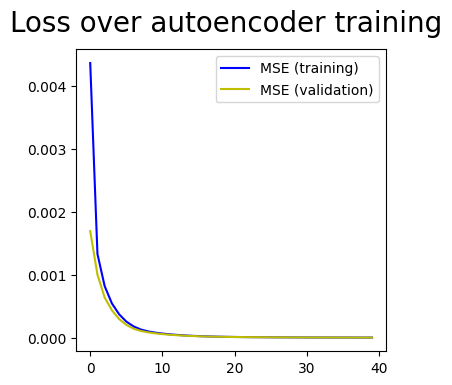

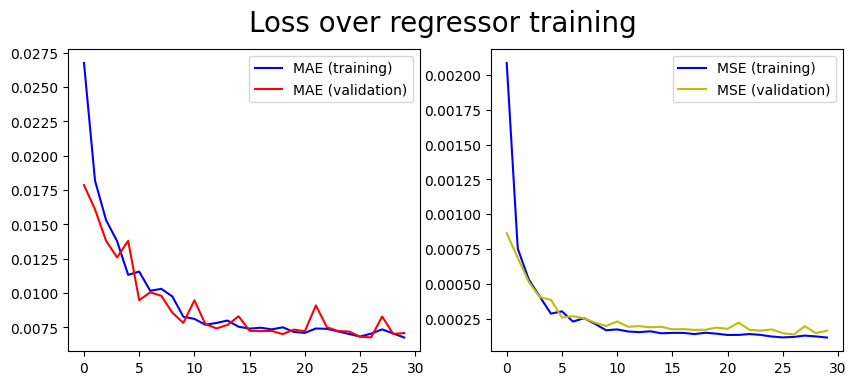

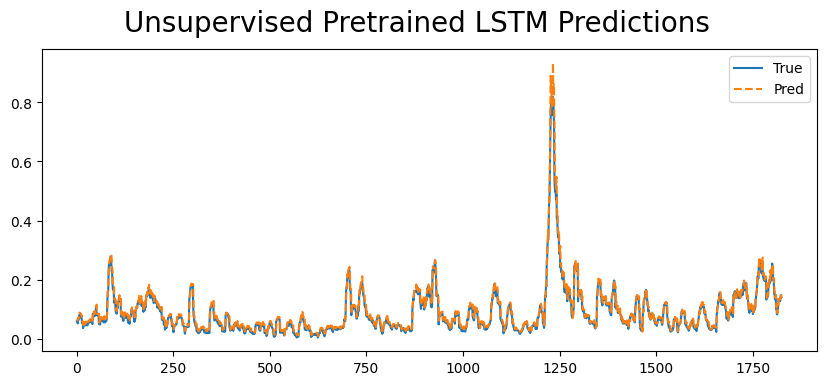

In [26]:
if PROGRESSIVE_TRAINING:
    # autoencoder loss plots
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
    fig.suptitle("Loss over autoencoder training", fontsize=20)

    ax.plot(enc_history['loss'], color='b', label="MSE (training)")
    ax.plot(enc_history['val_loss'], color='y', label="MSE (validation)")
    ax.legend(loc=0)


    # regressor loss plots
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
    fig.suptitle("Loss over regressor training", fontsize=20)

    ax[0].plot(reg_history['loss'], color='b', label="MAE (training)")
    ax[0].plot(reg_history['val_loss'], color='r', label="MAE (validation)")
    ax[0].legend(loc=0)

    ax[1].plot(reg_history['mse'], color='b', label="MSE (training)")
    ax[1].plot(reg_history['val_mse'], color='y', label="MSE (validation)")
    ax[1].legend(loc=0)


    # prediction plot
    y_pred_unsup = regressor.predict(X_test)
    y_pred_unsup = y_pred_unsup.flatten()

    fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=100)
    fig.suptitle("Unsupervised Pretrained LSTM Predictions", fontsize=20)

    ax.plot(y_test.flatten(), label='True')
    ax.plot(y_pred_unsup, linestyle='--', label='Pred')
    ax.legend(loc=0)

    plt.show()

In [27]:
if PROGRESSIVE_TRAINING:
    mae = np.abs(np.subtract(y_test.flatten(), y_pred_unsup)).mean()
    mse = np.square(np.subtract(y_test.flatten(), y_pred_unsup)).mean()
    mape = np.abs((y_test.flatten() - y_pred_unsup) / y_test.flatten()).mean() * 100

    _msle = pd.DataFrame(np.subtract(np.log(y_test.flatten() + 1), np.log(y_pred_unsup + 1)))
    _msle.dropna(inplace=True)
    msle = float(np.square(_msle).mean())

    print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")
    print(f"autoencoder training time = {total_enc_time:.2f}s; regressor training time = {total_reg_time:.2f}s; total time = {total_enc_time + total_reg_time:.2f}s")

mae = 0.00984; mse = 0.00025; msle = 0.00017; mape = 16.73933%
autoencoder training time = 54.35s; regressor training time = 65.19s; total time = 119.54s


### Active Learning

In [28]:
# GSx sampling for initial seed pool
def initial_selection(X, y, k=AL_SAMPLE):
    # select first sample as closest to centroid of all training samples
    centroid = np.mean(X, axis=0)

    # compute euclidean distance
    distances = np.max(np.linalg.norm(X - centroid, axis=2), axis=1)

    # select instances with smallest distance
    train_indices = np.argpartition(distances, k)[:k]
    X_instances = X[train_indices]
    y_instances = y[train_indices]

    # gather remaining instances
    val_indices = np.setdiff1d(range(X.shape[0]), train_indices)
    X_instances_val = X[val_indices]
    y_instances_val = y[val_indices]

    return X_instances, y_instances, X_instances_val, y_instances_val


# GSy sampling for selecting instances to add to training pool
def select_instances(model, X_t, y_t, X_v, y_v, k=AL_SAMPLE):
    # generate outputs y over validation set
    y_pred = model.predict(X_v)
    
    # for each prediction, find the minimum distance to an output in the training set
    _y_pred = y_pred.flatten()
    _y_t = y_t.flatten()
    distances = np.min(np.abs(_y_pred[:, np.newaxis] - _y_t), axis=1)

    # select new training instances as those furthest from training set outputs
    train_indices = np.argpartition(distances, -k)[-k:]
    val_indices = np.setdiff1d(range(X_v.shape[0]), train_indices)

    X_t = np.append(X_t, X_v[train_indices], axis=0)
    y_t = np.append(y_t, y_v[train_indices], axis=0)
    X_v = X_v[val_indices]
    y_v = y_v[val_indices]

    return X_t, y_t, X_v, y_v

In [29]:
if ACTIVE_LEARNING:
    # build RNN/LSTM architecture
    lstm_model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
        Dense(1, activation='linear')
    ])

    adam_opt = Adam(learning_rate=0.001, decay=1e-5)
    lstm_model.compile(loss='mae', optimizer=adam_opt, metrics=['mse'])

In [30]:
if ACTIVE_LEARNING:
    # active learning training
    histories = {}
    total_time_al = 0

    # initial training over seed dataset
    _start = time()
    X_pool, y_pool, X_val, y_val = initial_selection(X_train, y_train)
    history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT, verbose=False)
    total_time_al += time() - _start

    # store metrics
    histories.update({
        'loss': [np.min(history.history['loss'])],
        'mse': [np.min(history.history['mse'])],
        'val_loss': [np.min(history.history['val_loss'])],
        'val_mse': [np.min(history.history['val_mse'])]
    })

    # iteratively train model
    for it in range(AL_ITERATIONS):
        print(f"Iteration {it+1}/{AL_ITERATIONS}; pool = {X_pool.shape[0]}, val = {X_val.shape[0]}")
        if X_val.shape[0] >= AL_SAMPLE:
            _start = time()

            # use GSy method to select samples to add to the training pool
            X_pool, y_pool, X_val, y_val = select_instances(lstm_model, X_pool, y_pool, X_val, y_val)

            # train model over pool
            history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
            total_time_al += time() - _start
            
            # store metrics
            histories['loss'].append(np.min(history.history['loss']))
            histories['mse'].append(np.min(history.history['mse']))
            histories['val_loss'].append(np.min(history.history['val_loss']))
            histories['val_mse'].append(np.min(history.history['val_mse']))
        else:
            break

Iteration 1/70; pool = 100, val = 16325
Epoch 1/2
1/1 [==============================] - 0s 71ms/step - loss: 0.0233 - mse: 6.1512e-04 - val_loss: 0.0318 - val_mse: 0.0018
Epoch 2/2
1/1 [==============================] - 0s 85ms/step - loss: 0.0111 - mse: 1.7067e-04 - val_loss: 0.0188 - val_mse: 5.8337e-04
Iteration 2/70; pool = 200, val = 16225
Epoch 1/2
1/1 [==============================] - 0s 79ms/step - loss: 0.0101 - mse: 1.5463e-04 - val_loss: 0.0444 - val_mse: 0.0055
Epoch 2/2
1/1 [==============================] - 0s 64ms/step - loss: 0.0159 - mse: 3.3965e-04 - val_loss: 0.0440 - val_mse: 0.0054
Iteration 3/70; pool = 300, val = 16125
Epoch 1/2
2/2 [==============================] - 0s 86ms/step - loss: 0.0136 - mse: 2.5991e-04 - val_loss: 0.0340 - val_mse: 0.0036
Epoch 2/2
2/2 [==============================] - 0s 84ms/step - loss: 0.0078 - mse: 9.8191e-05 - val_loss: 0.0331 - val_mse: 0.0034
Iteration 4/70; pool = 400, val = 16025
Epoch 1/2
2/2 [=============================

In [31]:
if ACTIVE_LEARNING:
    lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 128)           69632     
                                                                 
 lstm_10 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
_________________________________________________________________


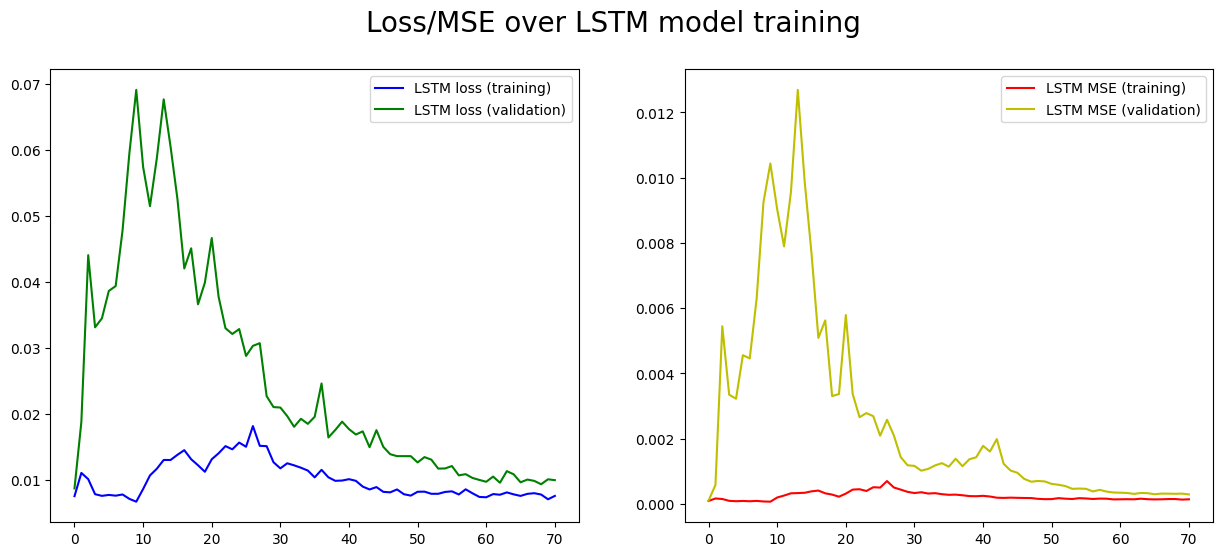

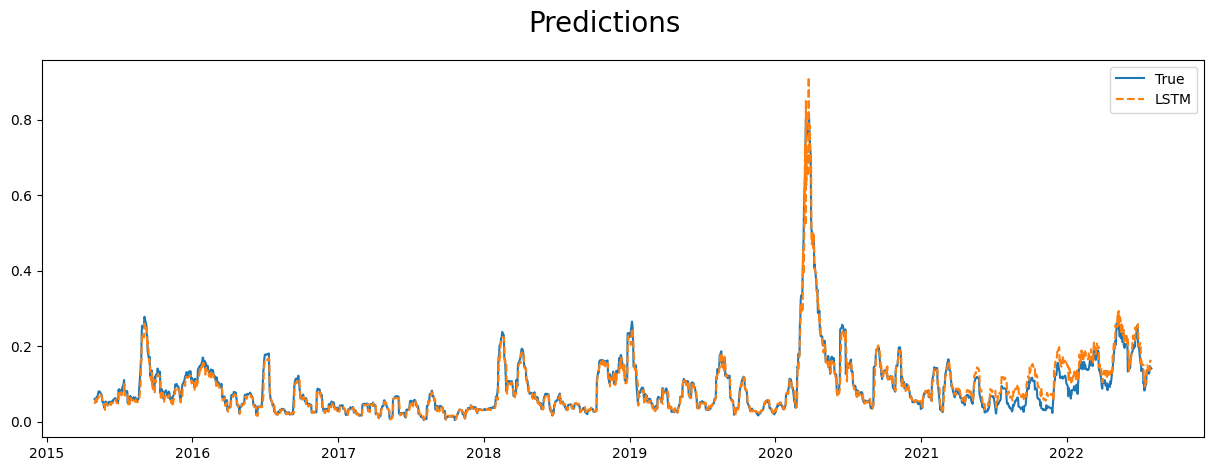

In [32]:
if ACTIVE_LEARNING:
    # training loss plot
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=100)
    fig.suptitle("Loss/MSE over LSTM model training", fontsize=20)

    ax[0].plot(histories['loss'], color='b', label="LSTM loss (training)")
    ax[0].plot(histories['val_loss'], color='g', label="LSTM loss (validation)")
    ax[0].legend(loc=0)

    ax[1].plot(histories['mse'], color='r', label="LSTM MSE (training)")
    ax[1].plot(histories['val_mse'], color='y', label="LSTM MSE (validation)")
    ax[1].legend(loc=0)

    # prediction plot
    y_pred_al = lstm_model.predict(X_test)
    y_pred_al = y_pred_al.flatten()
    y_test_plot = pd.Series(y_test.flatten(), index=X.returns[split + LOOKBACK_WINDOW:].keys())

    fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=100)
    fig.suptitle("Predictions", fontsize=20)

    y_pred_plot = pd.Series(y_pred_al, index=X.returns[split + LOOKBACK_WINDOW:].keys())

    ax.plot(y_test_plot, label='True')
    ax.plot(y_pred_plot, linestyle='--', label='LSTM')
    ax.legend(loc=0)

    plt.show()

In [33]:
if ACTIVE_LEARNING:
    mae = np.abs(np.subtract(y_test.flatten(), y_pred_al)).mean()
    mse = np.square(np.subtract(y_test.flatten(), y_pred_al)).mean()
    mape = np.abs((y_test.flatten() - y_pred_al) / y_test.flatten()).mean() * 100

    _msle = pd.DataFrame(np.subtract(np.log(y_test.flatten() + 1), np.log(y_pred_al + 1)))
    _msle.dropna(inplace=True)
    msle = float(np.square(_msle).mean())

    print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")
    print(f"training time = {total_time_al:.2f}s")

mae = 0.01215; mse = 0.00041; msle = 0.00029; mape = 16.69895%
training time = 183.32s
